## Importing Necessary Libraries
---



---



In [3]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import learning_curve
from joblib import dump

## Load preprocessed data
---



---


In [4]:
X_train = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X_train.pkl")
X_test = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X_test.pkl")
y_train = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y_train.pkl")
y_test = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y_test.pkl")
X = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X.pkl")
y = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y.pkl")    

## # Adjusting the class labels to start from 0
---



---


In [5]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

## # Adjusting the class labels to start from 0
---



---


In [6]:
# Initialize CatBoost model with predefined hyperparameters for tuning
model = CatBoostClassifier(random_state=42, verbose=0)  # verbose=0 for silent training


##  Define the hyperparameters and their possible values
---



---


In [7]:
param_grid = {
    'depth': [3, 6, 10],
    'learning_rate': [0.03, 0.1],
    'iterations': [500, 1000]
}

##  # Initialize GridSearchCV
---



---


In [8]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


##  Fit the model to the training data
---



---


In [9]:
grid_search.fit(X_train, y_train_adjusted)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x2b1b611d0>,
             n_jobs=-1,
             param_grid={'depth': [3, 6, 10], 'iterations': [500, 1000],
                         'learning_rate': [0.03, 0.1]},
             scoring='accuracy')

##  Best model
---



---


In [10]:
best_model = grid_search.best_estimator_

##  Predictions
---



---


In [11]:
y_pred_train_catboost = best_model.predict(X_train)
y_pred_test_catboost = best_model.predict(X_test)
dump(best_model, '/Users/pranavkhot/Documents/Fetal Health Project/trained_models/best_cat_model.pkl')

['/Users/pranavkhot/Documents/Fetal Health Project/trained_models/best_cat_model.pkl']

##  Calculate accuracy and f1-score
---



---


In [12]:
# Calculate accuracy and f1-score
catboost_accuracy_test = accuracy_score(y_test_adjusted, y_pred_test_catboost) * 100
catboost_accuracy_train = accuracy_score(y_train_adjusted, y_pred_train_catboost) * 100
catboost_f1 = f1_score(y_test_adjusted, y_pred_test_catboost, average='weighted') * 100
catboost_accuracy_overall = (catboost_accuracy_test + catboost_accuracy_train) / 2

# Create a dictionary to store different metrics
metrics_dict_catboost = {
    "Model": ["CatBoost Classifier"],
    "Train Accuracy": [f"{catboost_accuracy_train:.3f}%"],
    "Test Accuracy": [f"{catboost_accuracy_test:.3f}%"],
    "Overall Accuracy": [f"{catboost_accuracy_overall:.3f}%"],
    "F1-Score": [f"{catboost_f1:.3f}%"],
}

# Convert the dictionary to a DataFrame
metrics_df_catboost = pd.DataFrame(metrics_dict_catboost)

# Print metrics
print("\nCatBoost Classifier Metrics:")
print(tabulate(metrics_df_catboost, headers='keys', tablefmt='fancy_grid', showindex=False))

# Save the DataFrame to a CSV file
metrics_df_catboost.to_csv("/Users/pranavkhot/Documents/Fetal Health Project/results/CAT/cat_metrics.csv", index=False)




CatBoost Classifier Metrics:
╒═════════════════════╤══════════════════╤═════════════════╤════════════════════╤════════════╕
│ Model               │ Train Accuracy   │ Test Accuracy   │ Overall Accuracy   │ F1-Score   │
╞═════════════════════╪══════════════════╪═════════════════╪════════════════════╪════════════╡
│ CatBoost Classifier │ 99.882%          │ 96.948%         │ 98.415%            │ 96.888%    │
╘═════════════════════╧══════════════════╧═════════════════╧════════════════════╧════════════╛


##  Classification report
---



---


In [13]:
class_names = ['Normal', 'Suspect', 'Pathologic']
report = classification_report(y_test_adjusted, y_pred_test_catboost, output_dict=True, target_names=class_names)
df_report = pd.DataFrame(report).transpose()
print("\nClassification Report:")
print(tabulate(df_report, headers='keys', tablefmt='fancy_grid'))


Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤════════════╕
│              │   precision │   recall │   f1-score │    support │
╞══════════════╪═════════════╪══════════╪════════════╪════════════╡
│ Normal       │    0.967742 │ 0.993976 │   0.980684 │ 332        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Suspect      │    0.980769 │ 0.864407 │   0.918919 │  59        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ Pathologic   │    0.969697 │ 0.914286 │   0.941176 │  35        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ accuracy     │    0.969484 │ 0.969484 │   0.969484 │   0.969484 │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ macro avg    │    0.972736 │ 0.924223 │   0.946926 │ 426        │
├──────────────┼─────────────┼──────────┼────────────┼────────────┤
│ weighted avg │    0.969707 │ 0.969484 │   0.968883 │ 426        │
╘══════════════╧════════

##  Confusion matrix
---



---


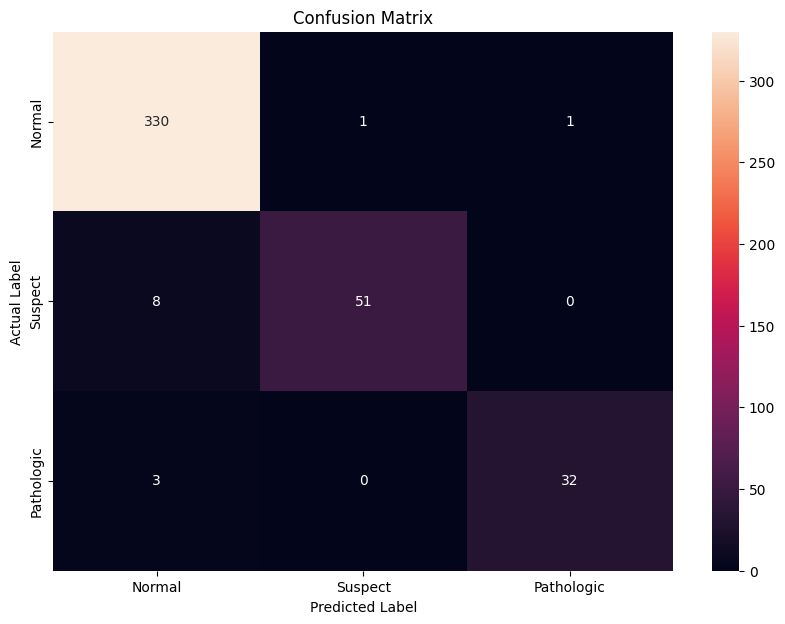

In [14]:
cm = confusion_matrix(y_test_adjusted, y_pred_test_catboost)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

##  Plot the learning curve
---



---


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


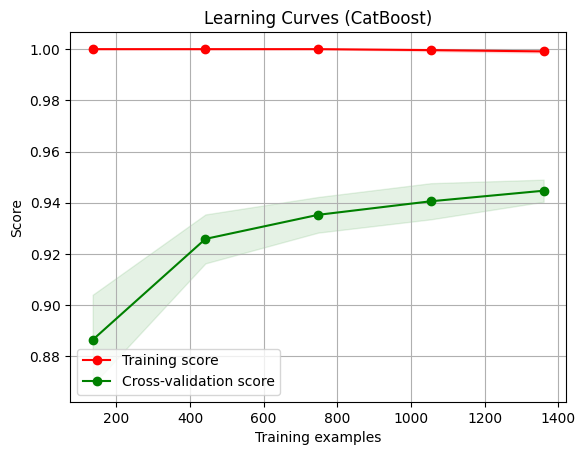

In [15]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

title = "Learning Curves (CatBoost)"
cv = 5  # Number of folds for cross-validation
plot_learning_curve(best_model, title, X_train, y_train_adjusted, cv=cv, n_jobs=-1)
plt.show()

In [1]:
import pandas as pd
from joblib import load

# Load the trained CatBoost model
model = load('/Users/pranavkhot/Documents/Fetal Health Project/trained_models/best_cat_model.pkl')

# Feature names
features = [
    "baseline value", "accelerations", "fetal_movement", 
    "uterine_contractions", "light_decelerations", "severe_decelerations", 
    "prolongued_decelerations", "abnormal_short_term_variability", 
    "mean_value_of_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability",
    "mean_value_of_long_term_variability", "histogram_width", 
    "histogram_min", "histogram_max", "histogram_number_of_peaks", 
    "histogram_number_of_zeroes", "histogram_mode", "histogram_mean", 
    "histogram_median", "histogram_variance", "histogram_tendency"
]

# Take user inputs from the terminal
print("Please enter the following fetal health parameters:")

user_input = []
for feature in features:
    value = input(f"{feature}: ")
    user_input.append(float(value))

# Convert the user input into a DataFrame
input_data = pd.DataFrame([user_input], columns=features)

# Make the prediction
prediction = model.predict(input_data)

# Mapping of the predicted class label to the fetal health
mapping = {0: 'Normal', 1: 'Suspect', 2: 'Pathologic'}

# Print the predicted class
print(f"\nPredicted Fetal Health: {mapping[int(prediction[0])]}")


Please enter the following fetal health parameters:


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

# Load the dataset
data = pd.read_csv('/Users/pranavkhot/Documents/Fetal Health Project/data/processed_data.csv')

# Selecting features and target
X = data.drop('fetal_health', axis=1)  # Assuming 'fetal_health' is the target variable
y = data['fetal_health']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balancing the training dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# CatBoost model definition
catboost_model = CatBoostClassifier(random_state=42)

# Hyperparameter Grid
param_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    # You can add more parameters here
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(catboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Training the model
grid_search.fit(X_train_balanced, y_train_balanced, verbose=100)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Predictions and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


0:	learn: 1.0892663	total: 59.2ms	remaining: 29.5s
0:	learn: 1.0886686	total: 60.3ms	remaining: 30.1s
0:	learn: 1.0894591	total: 59.5ms	remaining: 29.7s
0:	learn: 1.0112250	total: 59.2ms	remaining: 29.5s
0:	learn: 0.9190911	total: 57.4ms	remaining: 28.7s
0:	learn: 1.0886686	total: 59.8ms	remaining: 59.7s
0:	learn: 1.0092319	total: 62.8ms	remaining: 31.4s
0:	learn: 0.9333224	total: 56ms	remaining: 28s
0:	learn: 1.0036793	total: 61.6ms	remaining: 30.7s
0:	learn: 0.9292018	total: 63.8ms	remaining: 31.8s
100:	learn: 0.5419031	total: 553ms	remaining: 2.19s
100:	learn: 0.5589068	total: 568ms	remaining: 2.25s
100:	learn: 0.1498186	total: 552ms	remaining: 2.18s
100:	learn: 0.5498657	total: 626ms	remaining: 2.47s
100:	learn: 0.0946745	total: 605ms	remaining: 2.39s
100:	learn: 0.5419031	total: 620ms	remaining: 5.52s
100:	learn: 0.1282982	total: 636ms	remaining: 2.51s
100:	learn: 0.1026677	total: 640ms	remaining: 2.53s
100:	learn: 0.1583899	total: 663ms	remaining: 2.62s
100:	learn: 0.0739459	tota

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


499:	learn: 0.0109392	total: 1m 26s	remaining: 0us
0:	learn: 0.9021896	total: 166ms	remaining: 2m 46s
0:	learn: 0.8959936	total: 306ms	remaining: 5m 5s
500:	learn: 0.1158396	total: 1m 25s	remaining: 1m 25s
300:	learn: 0.2018001	total: 50.5s	remaining: 1m 57s
100:	learn: 0.0630335	total: 17s	remaining: 2m 31s
200:	learn: 0.2982876	total: 33.5s	remaining: 2m 12s
200:	learn: 0.0238105	total: 33.5s	remaining: 2m 13s
100:	learn: 0.0700241	total: 15.6s	remaining: 2m 18s
100:	learn: 0.0238787	total: 15.5s	remaining: 2m 17s
100:	learn: 0.0285261	total: 15.9s	remaining: 2m 21s
100:	learn: 0.0342973	total: 15.5s	remaining: 2m 17s
600:	learn: 0.0971909	total: 1m 41s	remaining: 1m 7s
400:	learn: 0.1558112	total: 1m 6s	remaining: 1m 38s
200:	learn: 0.0286481	total: 32.3s	remaining: 2m 8s
300:	learn: 0.2127386	total: 48.7s	remaining: 1m 53s
300:	learn: 0.0146447	total: 49.2s	remaining: 1m 54s
200:	learn: 0.0335553	total: 30.7s	remaining: 2m 2s
200:	learn: 0.0100958	total: 31.1s	remaining: 2m 3s
200: